In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, utils

from PIL import Image
import numpy as np

from collections import OrderedDict

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from models import Generator
from models import Discriminator
from dataset import transform_hl_pair
from dataset import arrange_data
from dataset import WIDER
from tools import show_grid

### Input Data Visulization

a basic idea of GAN in super-resolution applications is to generate a high-resolution image from a generator network and recognize this generated image by a discriminator.

In this implementation, I randomly cropped one face and one background per image of the WIDER train set. To train a generator, I separately resized patches to 128x128 and 32x32 as ground truth and input data. 

Below is the preprocessed images.

In [3]:
high_resolution = 128
trans_lr, trans_hr = transform_hl_pair(high_resolution, high_resolution)
train_path = "./WIDER/WIDER_train/images/"
val_path = "./WIDER/WIDER_val/images/"
anno_path = "./WIDER/wider_face_split/wider_face_val_bbx_gt.txt"

path, bbxs = arrange_data(anno_path)
wider = WIDER(val_path, path, bbxs)
dataloader = DataLoader(wider, batch_size=16, shuffle=True, num_workers=8)
batch = next(iter(dataloader))

use random noise.


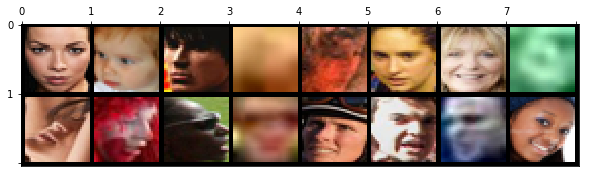

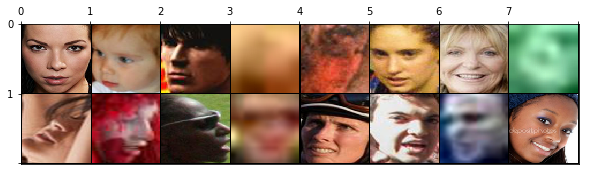

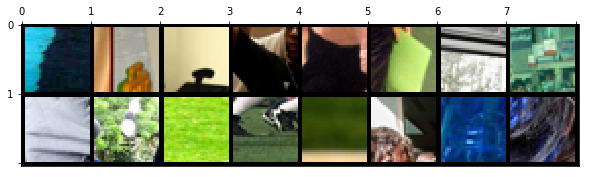

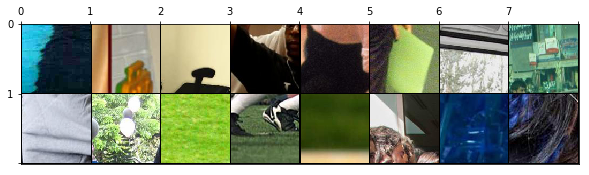

In [4]:
show_grid(batch["lr_face"])
show_grid(batch["hr_face"])
show_grid(batch["lr_background"])
show_grid(batch["hr_background"])

### Test for Generator Trained by SRGAN

To overcome the unbalance problem of generator and discriminator training process, I first initialize a generator of the upsample-refinement structure by SR-GAN according to [].

In [5]:
# load srgan generator weights
weights_ = torch.load("./models/generator_40.pth")
weights = OrderedDict()
for k, v in weights_.items():
    weights[k.split('module.')[-1]] = v

gen_srgan = Generator(3)
gen_srgan.load_state_dict(weights)
gen_srgan = gen_srgan.eval()

In [6]:
gen_hr1, gen_hr2 = gen_srgan(batch["lr_face"])

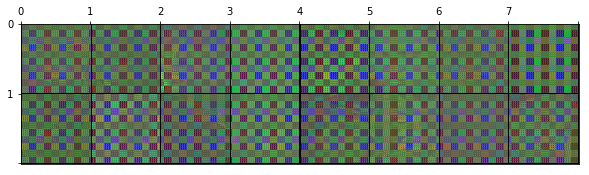

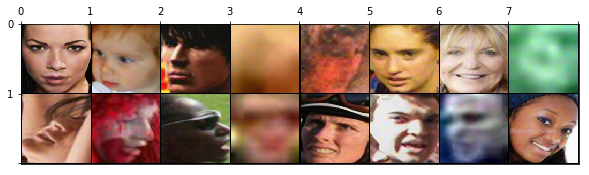

In [7]:
show_grid(gen_hr1)
show_grid(gen_hr2)

### single image inference

In [8]:
# load image
img = Image.open("./imgs/000002.jpg")

# ground truth image
img_lr = trans_lr(img).unsqueeze(0)

# resize image 
img_hr = trans_hr(img).unsqueeze(0)

# generator inference 
g1, g2 = gen_srgan(img_lr)

# recover from normalization
g1_recover = torch.clamp(g1*0.5 + 0.5, 0, 1)
g2_recover = torch.clamp(g2*0.5 + 0.5, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


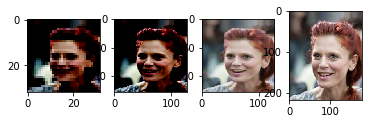

In [9]:
figure, ax=plt.subplots(1, 4)
f = lambda x:np.transpose(x.squeeze(), (1, 2, 0))
ax[0].imshow(f(img_lr)) # input
ax[1].imshow(f(img_hr)) # label
ax[2].imshow(f(g2_recover.detach())) # predicted result
ax[3].imshow(img) # original image

### Test for Generator Trained by Finding-Tiny-Face GAN



In [10]:
weights_ = torch.load("./saved_models/generator_5.pth")
gen_srgan2 = Generator(3)
gen_srgan2.load_state_dict(weights)
gen_srgan2 = gen_srgan.eval()

In [11]:
gen_hr1, gen_hr2 = gen_srgan2(batch["lr_face"])

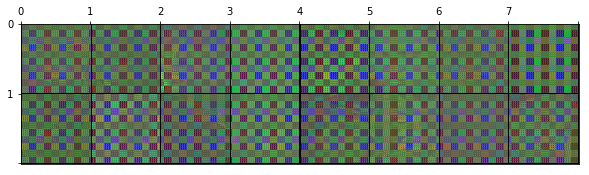

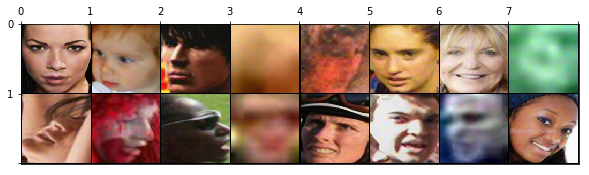

In [12]:
show_grid(gen_hr1)
show_grid(gen_hr2)

Both generated results seem clear. However, the Finding-Tiny-Face GAN generates easier faces to recognize. This difference is not easily noticeable by the human eye.

More details will be added ...